In [53]:
import random
from dro import OnlineDRO
import numpy as np
import matplotlib.pyplot as plt
import collections as col
import math


In [59]:
class DiscountedAverage:
    def __init__(self, tau):
        self.tau = tau
        self.sumr = 0
        self.n = 0
    
    def update(self, r):
        self.sumr = self.tau * self.sumr + r
        self.n = self.tau * self.n + 1
    
    def current(self):
        try:
            return self.sumr / self.n
        except:
            print(f'fuu r: {self.sumr} tau: {self.tau} n: {self.n}')
            raise Exception('you done')

class MovingAverage:
    def __init__(self, size):
        self.samples = col.deque()
        self.size = size
    
    def update(self, r):
        self.samples.append(r)
        if len(self.samples) > self.size:
            self.samples.popleft()
    
    def current(self):
        return sum(self.samples) / len(self.samples)

def gen_pmf(actions, epsilon, exploit_idx):
    pmf = [epsilon / actions] * actions
    pmf[exploit_idx] += 1 - epsilon
    return pmf

def sample_custom_pmf(pmf, rng):
    total = sum(pmf)
    scale = 1 / total
    pmf = [x * scale for x in pmf]
    draw = rng.random()
    sum_prob = 0.0
    for index, prob in enumerate(pmf):
        sum_prob += prob
        if(sum_prob > draw):
            return index
    raise Exception("can't sample")

In [60]:

def run_2(policy, eval, get_reward, count, tau, rng):
    m_size = int(1 / (1 - tau)) + 1

    ci = OnlineDRO.OnlineCressieReadLB(alpha=0.05, tau=tau)
    avg = DiscountedAverage(tau=tau)
    avg2 = MovingAverage(size=m_size)
    w_avg = DiscountedAverage(tau=tau)
    w_avg2 = MovingAverage(size=m_size)

    avg_lst = []
    avg2_lst = []
    w_avg_lst = []
    w_avg2_lst = []
    lb_lst = []
    for i in range(count):
       p_action = sample_custom_pmf(policy,rng)
       e_action = sample_custom_pmf(eval, rng)
       reward = get_reward(i, p_action)

       w = 1 / policy[p_action]
       if p_action != e_action:
           w = 0
       ci.update(c=1, w=w, r=reward)
       avg.update(reward)
       avg2.update(reward)
       w_avg.update(w)
       w_avg2.update(w)
       ci.recomputeduals()

       avg_lst.append(avg.current())
       avg2_lst.append(avg2.current())
       w_avg_lst.append(w_avg.current())
       w_avg2_lst.append(w_avg2.current())
       lb_lst.append(ci.duals[0][0])
    dump_stats()
    return (lb_lst, avg_lst, avg2_lst, w_avg_lst, w_avg2_lst)

def switch_midpoint(idx, action, limit, p0, p1):
    if idx < limit:
        return p0[action]
    return p1[action]



mu 0.5009149702069291 si 0.2901040599642057
mu 0.4975797747817585 si 0.29008768109391825
mu 0.49821453334286336 si 0.2896862941260014
mu 0.5020038853878804 si 0.2891178510646435
mu 0.49655774020168375 si 0.2878407960441547
mu 0.49838379975547475 si 0.28712358292585294
mu 0.5052126636570329 si 0.2863816857075974
mu 0.4984995263280235 si 0.2886568478678969
mu 0.5014803247967082 si 0.28957676893444256
mu 0.49822926954442454 si 0.28784331497047794
mu 0.497490961854373 si 0.2902854250224711
mu 0.48784617808926595 si 0.28934128884390264
mu 0.4982767916992502 si 0.2919167718358601
mu 0.4965039943919366 si 0.287105850789444
mu 0.5008404477855296 si 0.2902878059018459
mu 0.5071224979809679 si 0.2879941857840089
mu 0.49886273546449167 si 0.2878443704608898
mu 0.5010503487455645 si 0.2917724612290822
mu 0.4967037431653175 si 0.2867933516681376
mu 0.5007593873003995 si 0.2886218917571412


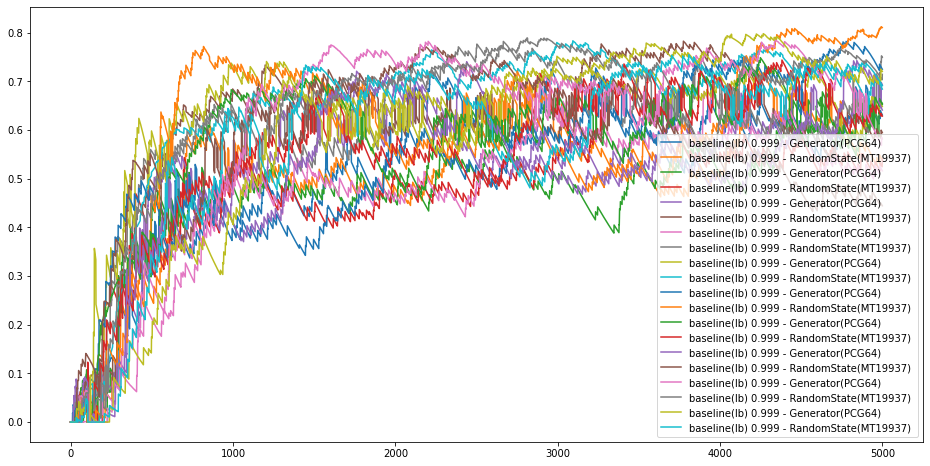

In [62]:

policy = gen_pmf(4, 0.2, 3)
baseline = gen_pmf(4, 0.2, 0)

p0_reward = [0.1, 0.3, 0.3, 1]
p1_reward = [1, 0.3, 0.3, 0.1]

count = 5000
switch_point = 100

def plot_stuff(tau, rng=None):
    gr = lambda i,a : switch_midpoint(i, a, switch_point, p0_reward, p1_reward)
    res = run_2(policy, baseline, gr, count, tau, rng)
    plt.plot(res[0], label=f'baseline(lb) {tau} - {rng} ')


plt.figure(figsize=(16, 8))

for i in range(10):
    plot_stuff(0.999,  np.random.default_rng(i * 37 + 7))
    plot_stuff(0.999,  np.random.RandomState(i * 37 + 7))
plt.legend()
